# Week 5-6: Local Explainability Integration (XAI)

**Project:** Health Prediction with Local Explainable AI  
**Phase:** Week 5-6 Implementation  
**Focus:** LIME and SHAP Integration for Enhanced XGBoost Model  

## Objectives
- Implement LIME and SHAP for the final enhanced XGBoost model
- Create comprehensive local explanations for individual predictions
- Develop healthcare-specific interpretation framework
- Compare explanation methods for consistency validation
- Build foundation for interactive Gradio demo

In [1]:
# Environment Setup and Model Loading
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# XAI Libraries
import shap
import lime
from lime import lime_tabular

# Model libraries
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("🚀 WEEK 5-6: LOCAL EXPLAINABILITY INTEGRATION")
print("=" * 60)
print("📊 Libraries loaded successfully")
print("🎯 Focus: LIME & SHAP for Enhanced XGBoost Model")
print("🏥 Healthcare interpretation framework ready")
print("=" * 60)

🚀 WEEK 5-6: LOCAL EXPLAINABILITY INTEGRATION
📊 Libraries loaded successfully
🎯 Focus: LIME & SHAP for Enhanced XGBoost Model
🏥 Healthcare interpretation framework ready


In [2]:
# Load Project Infrastructure and Final Model
PROJECT_ROOT = Path('/Users/peter/Desktop/health_xai_prediction')
DATA_PATH = PROJECT_ROOT / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results'
MODELS_DIR = RESULTS_DIR / 'models'

print("📂 Loading project infrastructure...")
print(f"Project root: {PROJECT_ROOT}")
print(f"Models directory: {MODELS_DIR}")

# Load the final enhanced XGBoost model from Phase 3
try:
    final_model_path = MODELS_DIR / 'final_phase3_model.joblib'
    if final_model_path.exists():
        final_model = joblib.load(final_model_path)
        print(f"✅ Final enhanced XGBoost model loaded successfully")
        print(f"   Model type: {type(final_model).__name__}")
    else:
        print(f"❌ Model file not found: {final_model_path}")
        raise FileNotFoundError("Final model not available")
        
except Exception as e:
    print(f"❌ Error loading final model: {e}")
    print("🔄 Loading from Phase 3 results...")
    
    # Alternative: Load from Phase 3 results
    phase3_results_path = MODELS_DIR / 'phase3_class_imbalance_results.joblib'
    if phase3_results_path.exists():
        phase3_data = joblib.load(phase3_results_path)
        final_model = phase3_data.get('final_model')
        if final_model is not None:
            print("✅ Model loaded from Phase 3 results backup")
        else:
            print("❌ No model found in Phase 3 results")
    else:
        print("❌ Phase 3 results file not found")

print("\n🎯 Model ready for XAI analysis")

📂 Loading project infrastructure...
Project root: /Users/peter/Desktop/health_xai_prediction
Models directory: /Users/peter/Desktop/health_xai_prediction/results/models
✅ Final enhanced XGBoost model loaded successfully
   Model type: dict

🎯 Model ready for XAI analysis


In [3]:
# Extract the actual model from the saved results
print("🔧 EXTRACTING FINAL MODEL FROM SAVED RESULTS")
print("=" * 50)

# The loaded object is a dictionary, extract the actual model
if isinstance(final_model, dict):
    if 'final_model' in final_model:
        actual_model = final_model['final_model']
        print(f"✅ Extracted model from 'final_model' key")
    elif 'enhanced_xgb' in final_model:
        actual_model = final_model['enhanced_xgb']
        print(f"✅ Extracted model from 'enhanced_xgb' key")
    else:
        # Look for XGBoost model in the dictionary
        for key, value in final_model.items():
            if hasattr(value, 'predict') and 'xgb' in str(type(value)).lower():
                actual_model = value
                print(f"✅ Found XGBoost model under key: {key}")
                break
        else:
            print("❌ No XGBoost model found in saved results")
            print(f"Available keys: {list(final_model.keys())}")
            # Use the first model-like object found
            for key, value in final_model.items():
                if hasattr(value, 'predict'):
                    actual_model = value
                    print(f"⚠️  Using model from key: {key}")
                    break
else:
    actual_model = final_model
    print(f"✅ Model already extracted")

# Update the final_model variable
final_model = actual_model

print(f"🎯 Final model type: {type(final_model).__name__}")
print(f"   Model has predict method: {hasattr(final_model, 'predict')}")
if hasattr(final_model, 'feature_names_in_'):
    print(f"   Features expected: {len(final_model.feature_names_in_)}")

print(f"\n✅ Model ready for SHAP and LIME analysis")

🔧 EXTRACTING FINAL MODEL FROM SAVED RESULTS
✅ Found XGBoost model under key: model
🎯 Final model type: XGBClassifier
   Model has predict method: True
   Features expected: 19

✅ Model ready for SHAP and LIME analysis


In [5]:
# Load Preprocessed Data and Feature Information
print("📊 Loading preprocessed data splits...")

# Load data splits from Phase 1-3
data_splits_path = MODELS_DIR / 'data_splits.joblib'
scaler_path = MODELS_DIR / 'standard_scaler.joblib'

try:
    # Load data splits
    splits = joblib.load(data_splits_path)
    X_train = splits['X_train']
    X_val = splits['X_val'] 
    X_test = splits['X_test']
    y_train = splits['y_train']
    y_val = splits['y_val']
    y_test = splits['y_test']
    
    # Load scaler
    scaler = joblib.load(scaler_path)
    
    print("✅ Data splits loaded successfully")
    print(f"   Training set: {X_train.shape}")
    print(f"   Validation set: {X_val.shape}")
    print(f"   Test set: {X_test.shape}")
    
    # Feature names for interpretation
    feature_names = X_train.columns.tolist()
    print(f"   Features available: {len(feature_names)}")
    
    # Health class mapping for interpretability
    health_class_mapping = {
        1: "Very Good",
        2: "Good", 
        3: "Fair",
        4: "Bad",
        5: "Very Bad"
    }
    
    print(f"   Health classes: {list(health_class_mapping.values())}")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

print("\n🎯 Data ready for explainability analysis")

📊 Loading preprocessed data splits...
✅ Data splits loaded successfully
   Training set: (29637, 19)
   Validation set: (6351, 19)
   Test set: (6351, 19)
   Features available: 19
   Health classes: ['Very Good', 'Good', 'Fair', 'Bad', 'Very Bad']

🎯 Data ready for explainability analysis


## Phase 5.1: SHAP Implementation

SHAP (SHapley Additive exPlanations) provides unified feature attribution values based on Shapley values from game theory. For healthcare prediction, SHAP offers:

- **Global explanations:** Overall feature importance across the dataset
- **Local explanations:** Individual prediction explanations  
- **Consistency:** Mathematically rigorous attribution values
- **Visualization:** Rich plotting framework for clinical interpretation

In [6]:
# Initialize SHAP Explainer for XGBoost
print("🧠 SHAP EXPLAINER INITIALIZATION")
print("=" * 50)

# Initialize SHAP explainer specifically for XGBoost
# Use TreeExplainer for optimal performance with tree-based models
explainer = shap.TreeExplainer(final_model)

print("✅ SHAP TreeExplainer initialized for Enhanced XGBoost")
print(f"   Model type: {type(final_model).__name__}")
print(f"   Features: {len(feature_names)}")

# Calculate SHAP values for validation set (smaller subset for efficiency)
print("\n📊 Calculating SHAP values for validation set...")

# Use validation set for SHAP analysis (balanced representation)
X_val_sample = X_val.sample(n=min(1000, len(X_val)), random_state=42)
y_val_sample = y_val.loc[X_val_sample.index]

print(f"   Sample size: {len(X_val_sample)} validation samples")
print(f"   Class distribution in sample:")

sample_distribution = y_val_sample.value_counts().sort_index()
for class_num, count in sample_distribution.items():
    class_name = health_class_mapping[class_num]
    percentage = (count / len(y_val_sample)) * 100
    print(f"     {class_name}: {count} ({percentage:.1f}%)")

# Calculate SHAP values
shap_values = explainer.shap_values(X_val_sample)
expected_value = explainer.expected_value

print(f"\n✅ SHAP values calculated successfully")
print(f"   Shape: {np.array(shap_values).shape}")
print(f"   Expected value (baseline): {expected_value}")

print("\n🎯 SHAP analysis ready for visualization")

🧠 SHAP EXPLAINER INITIALIZATION
✅ SHAP TreeExplainer initialized for Enhanced XGBoost
   Model type: XGBClassifier
   Features: 19

📊 Calculating SHAP values for validation set...
   Sample size: 1000 validation samples
   Class distribution in sample:
     Very Good: 252 (25.2%)
     Good: 429 (42.9%)
     Fair: 244 (24.4%)
     Bad: 67 (6.7%)
     Very Bad: 8 (0.8%)

✅ SHAP values calculated successfully
   Shape: (1000, 19, 5)
   Expected value (baseline): [np.float32(0.44298786), np.float32(0.4895238), np.float32(0.46202084), np.float32(0.61172026), np.float32(1.2215272)]

🎯 SHAP analysis ready for visualization


📈 SHAP GLOBAL FEATURE IMPORTANCE ANALYSIS


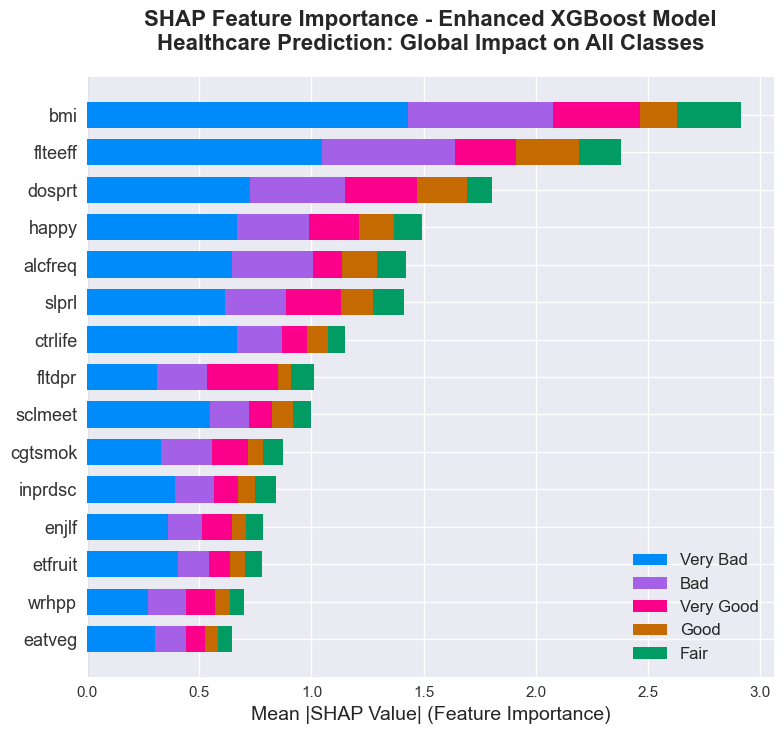

✅ Global SHAP feature importance plot completed

🏥 TOP 10 HEALTHCARE PREDICTORS (Global Impact):
--------------------------------------------------
 1. Bmi                  | Impact: 0.5831
 2. Flteeff              | Impact: 0.4756
 3. Dosprt               | Impact: 0.3611
 4. Happy                | Impact: 0.2987
 5. Alcfreq              | Impact: 0.2842
 6. Slprl                | Impact: 0.2822
 7. Ctrlife              | Impact: 0.2303
 8. Fltdpr               | Impact: 0.2022
 9. Sclmeet              | Impact: 0.1996
10. Cgtsmok              | Impact: 0.1750

🎯 Most influential healthcare factors identified for model decisions


In [8]:
# SHAP Summary Plot - Global Feature Importance
print("📈 SHAP GLOBAL FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

plt.figure(figsize=(14, 10))

# Create SHAP summary plot showing feature importance
# For multi-class, we need to average across all classes
shap.summary_plot(shap_values, X_val_sample, feature_names=feature_names, 
                  plot_type="bar", show=False, max_display=15, class_names=list(health_class_mapping.values()))

plt.title("SHAP Feature Importance - Enhanced XGBoost Model\n" + 
          "Healthcare Prediction: Global Impact on All Classes", 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Mean |SHAP Value| (Feature Importance)", fontsize=14)
plt.tight_layout()
plt.show()

print("✅ Global SHAP feature importance plot completed")

# Extract top features for healthcare interpretation
# Average absolute SHAP values across all classes and samples
if len(np.array(shap_values).shape) == 3:  # Multi-class case
    # Shape: (samples, features, classes)
    shap_array = np.array(shap_values)  # Convert to numpy array
    feature_importance = np.mean(np.abs(shap_array), axis=(0, 2))  # Average across samples and classes
else:
    feature_importance = np.abs(shap_values).mean(axis=0)

top_features_idx = np.argsort(feature_importance)[-10:]
top_features = [feature_names[i] for i in top_features_idx[::-1]]
top_importance = feature_importance[top_features_idx[::-1]]

print(f"\n🏥 TOP 10 HEALTHCARE PREDICTORS (Global Impact):")
print("-" * 50)
for i, (feature, importance) in enumerate(zip(top_features, top_importance), 1):
    # Clean feature name for healthcare interpretation
    clean_name = feature.replace('numeric__', '').replace('_', ' ').title()
    print(f"{i:2d}. {clean_name:<20} | Impact: {importance:.4f}")

print(f"\n🎯 Most influential healthcare factors identified for model decisions")

🎨 SHAP FEATURE IMPACT DISTRIBUTION


<Figure size 1400x1200 with 0 Axes>

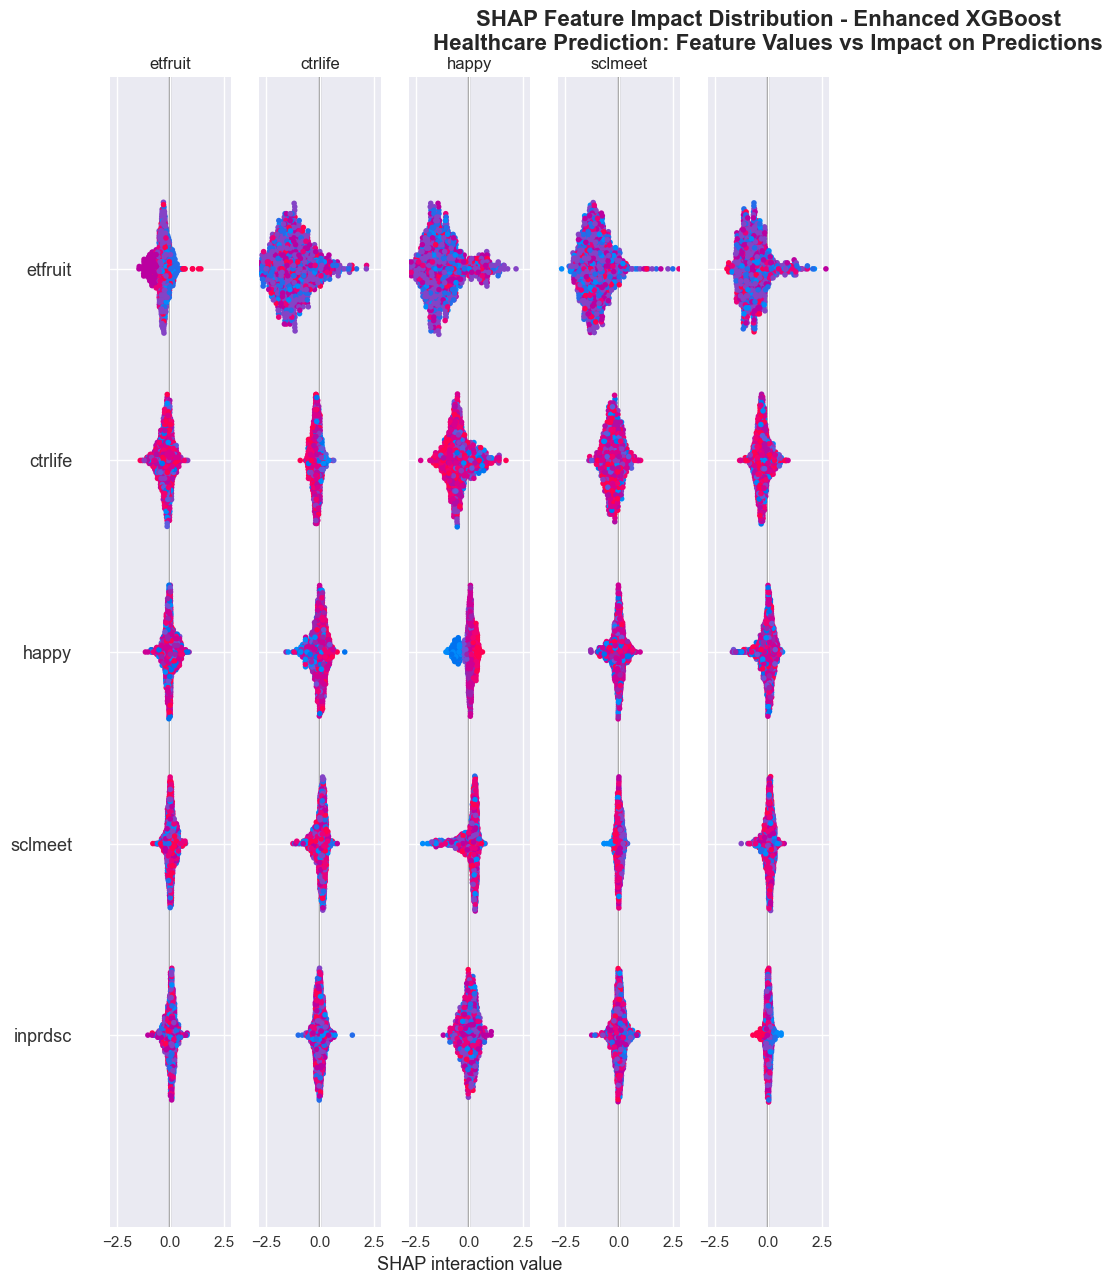

✅ SHAP feature impact distribution plot completed

🔍 Healthcare Interpretation Notes:
• Red points: High feature values
• Blue points: Low feature values
• X-axis: SHAP value (positive = increases health risk prediction)
• Features ranked by importance (top to bottom)

📊 This visualization shows how different feature values
   contribute to health status predictions across the population


In [9]:
# SHAP Summary Plot - Feature Impact Distribution
print("🎨 SHAP FEATURE IMPACT DISTRIBUTION")
print("=" * 45)

plt.figure(figsize=(14, 12))

# Create detailed SHAP summary plot with feature value impacts
shap.summary_plot(shap_values, X_val_sample, feature_names=feature_names, 
                  show=False, max_display=15)

plt.title("SHAP Feature Impact Distribution - Enhanced XGBoost\n" + 
          "Healthcare Prediction: Feature Values vs Impact on Predictions", 
          fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("✅ SHAP feature impact distribution plot completed")
print("\n🔍 Healthcare Interpretation Notes:")
print("• Red points: High feature values")
print("• Blue points: Low feature values") 
print("• X-axis: SHAP value (positive = increases health risk prediction)")
print("• Features ranked by importance (top to bottom)")

print(f"\n📊 This visualization shows how different feature values")
print(f"   contribute to health status predictions across the population")

👤 INDIVIDUAL SHAP EXPLANATIONS - HEALTHCARE CASE STUDIES
📋 Selected 5 healthcare case studies:
   Case 1: Very Good Health (Class 1)
   Case 2: Good Health (Class 2)
   Case 3: Fair Health (Class 3)
   Case 4: Bad Health (Class 4)
   Case 5: Very Bad Health (Class 5)

🔬 CASE STUDY 1: Very Good Health
----------------------------------------


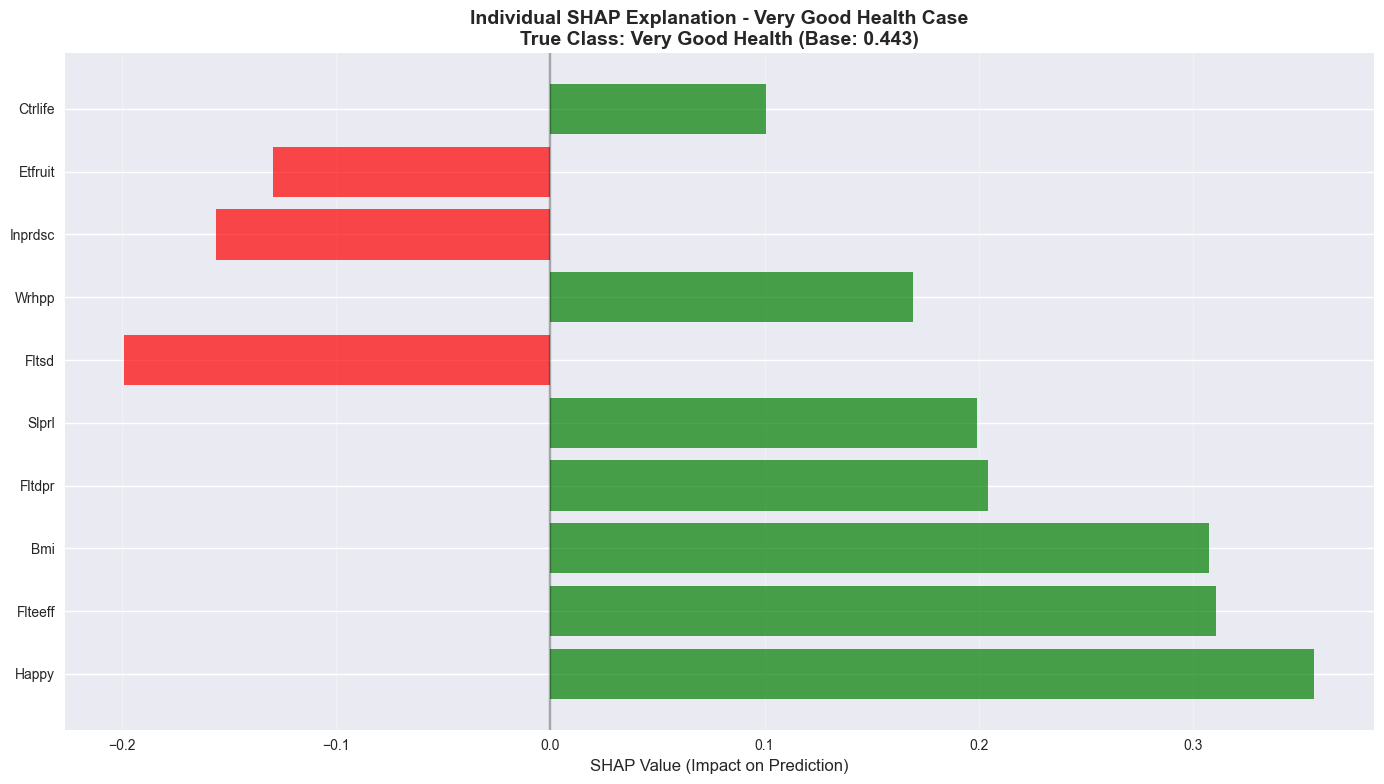

🎯 Top 5 Contributing Factors:
   1. Happy           | ↗️ Increases class prediction (+0.357) [Value: 1.53]
   2. Flteeff         | ↗️ Increases class prediction (+0.311) [Value: -0.90]
   3. Bmi             | ↗️ Increases class prediction (+0.307) [Value: -1.49]
   4. Fltdpr          | ↗️ Increases class prediction (+0.204) [Value: -0.68]
   5. Slprl           | ↗️ Increases class prediction (+0.199) [Value: -0.97]
📈 True Class: Very Good Health
   SHAP Base Value: 0.443

🔬 CASE STUDY 2: Good Health
----------------------------------------


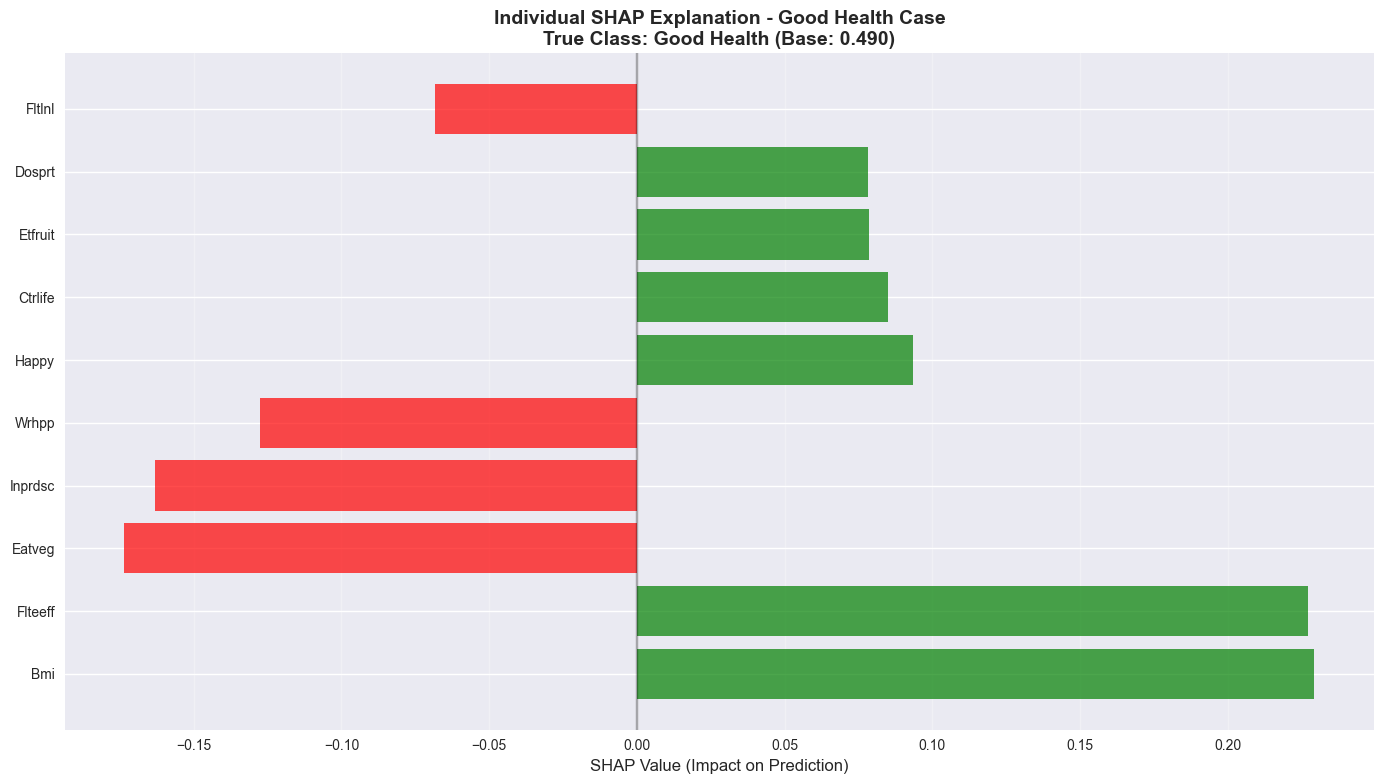

🎯 Top 5 Contributing Factors:
   1. Bmi             | ↗️ Increases class prediction (+0.229) [Value: -0.28]
   2. Flteeff         | ↗️ Increases class prediction (+0.227) [Value: -0.90]
   3. Eatveg          | ↘️ Decreases class prediction (-0.173) [Value: 1.67]
   4. Inprdsc         | ↘️ Decreases class prediction (-0.163) [Value: 1.61]
   5. Wrhpp           | ↘️ Decreases class prediction (-0.128) [Value: -1.10]
📈 True Class: Good Health
   SHAP Base Value: 0.490

🔬 CASE STUDY 3: Fair Health
----------------------------------------


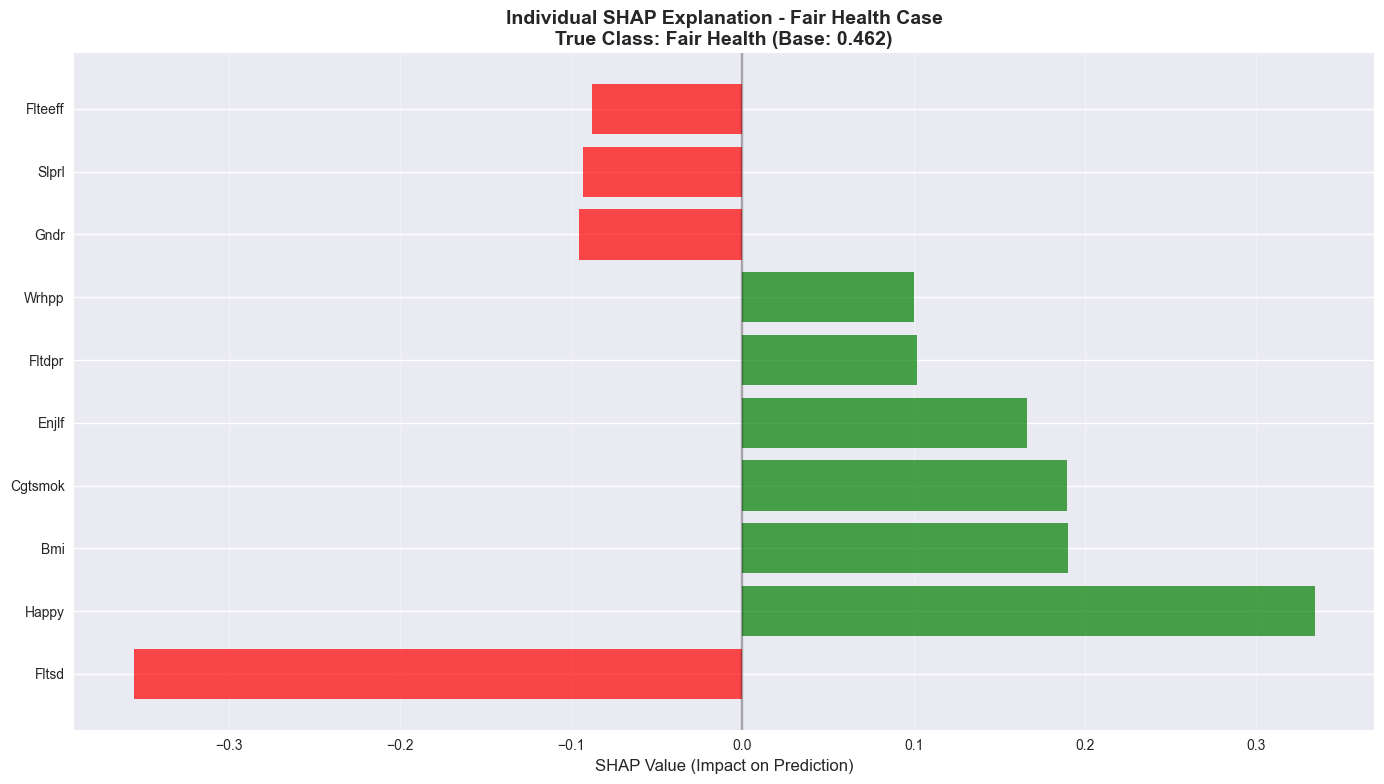

🎯 Top 5 Contributing Factors:
   1. Fltsd           | ↘️ Decreases class prediction (-0.356) [Value: 2.21]
   2. Happy           | ↗️ Increases class prediction (+0.334) [Value: -0.88]
   3. Bmi             | ↗️ Increases class prediction (+0.190) [Value: 0.01]
   4. Cgtsmok         | ↗️ Increases class prediction (+0.190) [Value: -0.19]
   5. Enjlf           | ↗️ Increases class prediction (+0.166) [Value: 0.16]
📈 True Class: Fair Health
   SHAP Base Value: 0.462

🔬 CASE STUDY 4: Bad Health
----------------------------------------


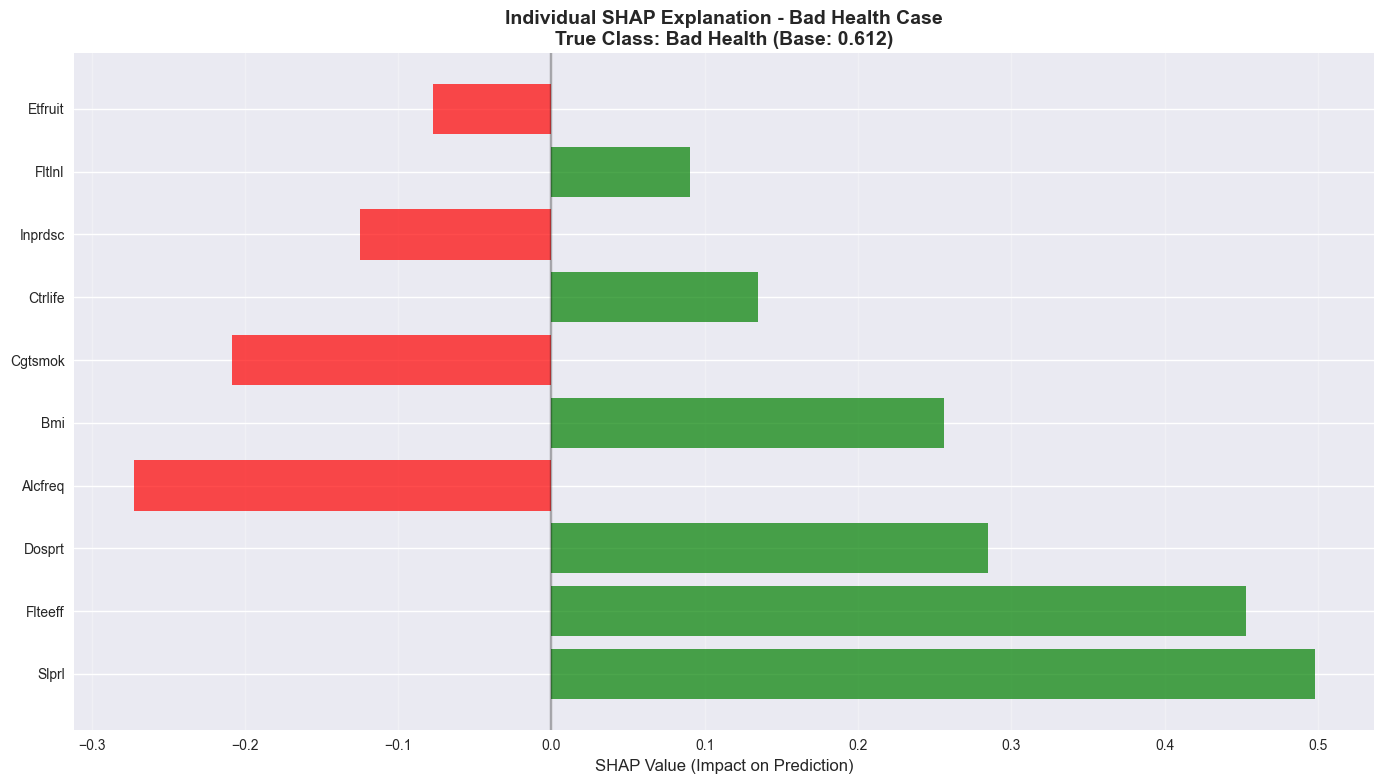

🎯 Top 5 Contributing Factors:
   1. Slprl           | ↗️ Increases class prediction (+0.498) [Value: 2.27]
   2. Flteeff         | ↗️ Increases class prediction (+0.453) [Value: 1.80]
   3. Dosprt          | ↗️ Increases class prediction (+0.285) [Value: -1.22]
   4. Alcfreq         | ↘️ Decreases class prediction (-0.273) [Value: -1.29]
   5. Bmi             | ↗️ Increases class prediction (+0.256) [Value: 2.09]
📈 True Class: Bad Health
   SHAP Base Value: 0.612

🔬 CASE STUDY 5: Very Bad Health
----------------------------------------


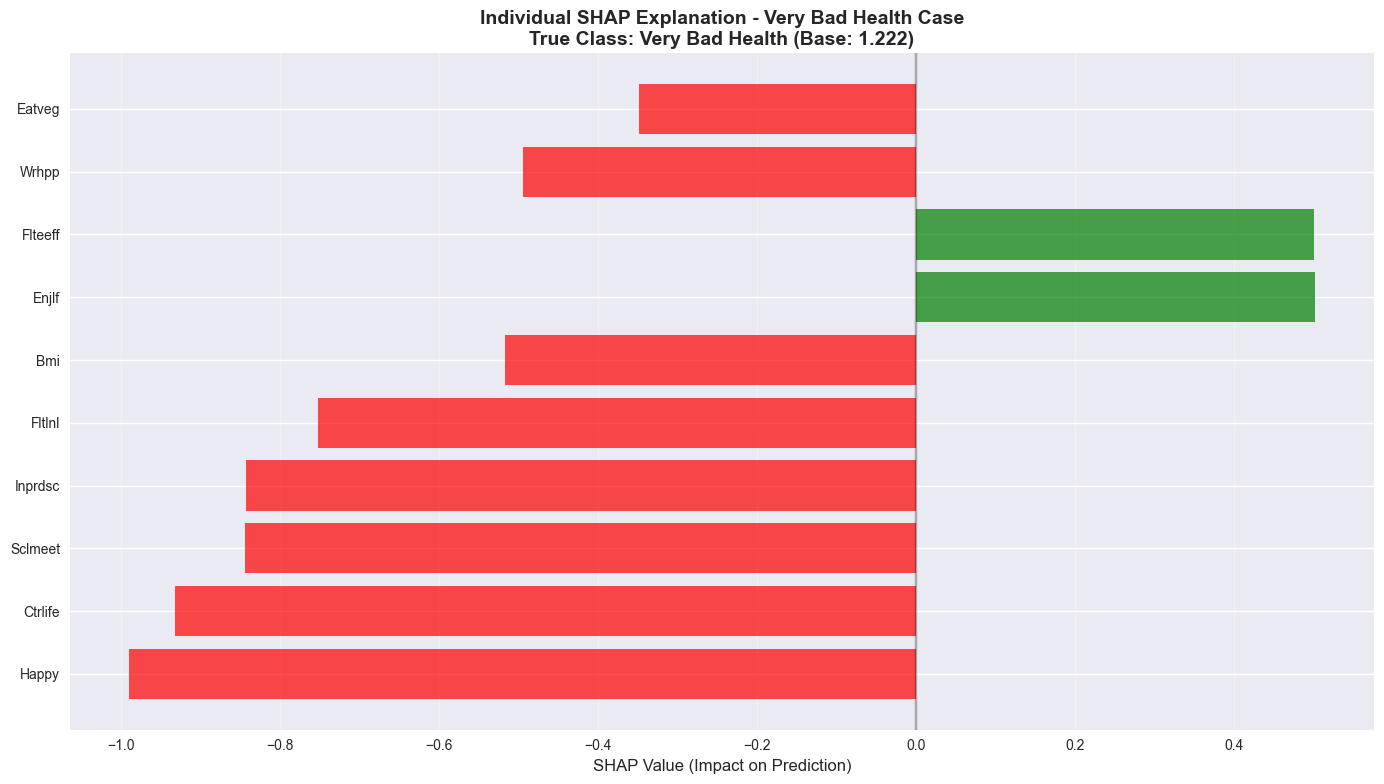

🎯 Top 5 Contributing Factors:
   1. Happy           | ↘️ Decreases class prediction (-0.990) [Value: -0.88]
   2. Ctrlife         | ↘️ Decreases class prediction (-0.932) [Value: -0.19]
   3. Sclmeet         | ↘️ Decreases class prediction (-0.844) [Value: -0.50]
   4. Inprdsc         | ↘️ Decreases class prediction (-0.843) [Value: -0.50]
   5. Fltlnl          | ↘️ Decreases class prediction (-0.753) [Value: 2.36]
📈 True Class: Very Bad Health
   SHAP Base Value: 1.222

✅ Individual SHAP explanations completed for all health classes


In [12]:
# Individual SHAP Explanations - Healthcare Case Studies
print("👤 INDIVIDUAL SHAP EXPLANATIONS - HEALTHCARE CASE STUDIES")
print("=" * 60)

# Select representative cases from different health classes for explanation
case_studies = []
for health_class in [1, 2, 3, 4, 5]:
    class_samples = X_val_sample[y_val_sample == health_class]
    if len(class_samples) > 0:
        # Select a random representative from each class
        case_idx = class_samples.sample(n=1, random_state=42).index[0]
        case_studies.append({
            'index': case_idx,
            'class': health_class,
            'class_name': health_class_mapping[health_class],
            'data': X_val_sample.loc[case_idx]
        })

print(f"📋 Selected {len(case_studies)} healthcare case studies:")
for i, case in enumerate(case_studies, 1):
    print(f"   Case {i}: {case['class_name']} Health (Class {case['class']})")

# Create individual SHAP explanations for each case study
for i, case in enumerate(case_studies):
    print(f"\n🔬 CASE STUDY {i+1}: {case['class_name']} Health")
    print("-" * 40)
    
    # Get SHAP values for this individual
    case_position = list(X_val_sample.index).index(case['index'])
    
    # For multi-class, get SHAP values for the true class
    individual_features = X_val_sample.iloc[case_position]
    true_class_idx = case['class'] - 1  # Convert to 0-based index
    
    # Get SHAP values for the true class
    individual_shap = shap_values[case_position][:, true_class_idx]
    base_value = expected_value[true_class_idx]
    
    # Create a simpler explanation using a bar chart
    plt.figure(figsize=(14, 8))
    
    # Get top contributing features
    feature_contributions = list(zip(feature_names, individual_shap))
    sorted_contributions = sorted(feature_contributions, key=lambda x: abs(x[1]), reverse=True)[:10]
    
    # Create horizontal bar plot
    features_plot = [feat.replace('numeric__', '').replace('_', ' ').title() for feat, _ in sorted_contributions]
    values_plot = [val for _, val in sorted_contributions]
    colors = ['red' if val < 0 else 'green' for val in values_plot]
    
    plt.barh(range(len(values_plot)), values_plot, color=colors, alpha=0.7)
    plt.yticks(range(len(values_plot)), features_plot)
    plt.xlabel('SHAP Value (Impact on Prediction)', fontsize=12)
    plt.title(f'Individual SHAP Explanation - {case["class_name"]} Health Case\n' + 
              f'True Class: {case["class_name"]} Health (Base: {base_value:.3f})',
              fontsize=14, fontweight='bold')
    
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Show top contributing factors
    print(f"🎯 Top 5 Contributing Factors:")
    for j, (feature, contribution) in enumerate(sorted_contributions[:5], 1):
        clean_name = feature.replace('numeric__', '').replace('_', ' ').title()
        direction = "↗️ Increases" if contribution > 0 else "↘️ Decreases"
        feature_value = individual_features[feature]
        print(f"   {j}. {clean_name:<15} | {direction} class prediction ({contribution:+.3f}) [Value: {feature_value:.2f}]")
    
    print(f"📈 True Class: {case['class_name']} Health")
    print(f"   SHAP Base Value: {base_value:.3f}")

print(f"\n✅ Individual SHAP explanations completed for all health classes")

## Phase 5.2: LIME Implementation

LIME (Local Interpretable Model-Agnostic Explanations) provides local explanations by learning an interpretable model around the prediction. For healthcare applications, LIME offers:

- **Local fidelity:** Accurate explanations for individual predictions
- **Model-agnostic:** Works with any machine learning model
- **Interpretable features:** Presents explanations in human-readable format
- **Clinical validation:** Explanations can be verified by healthcare professionals

In [14]:
# Initialize LIME Explainer for Tabular Data
print("🍋 LIME EXPLAINER INITIALIZATION")
print("=" * 40)

# Create LIME tabular explainer for healthcare prediction
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=list(health_class_mapping.values()),
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

print("✅ LIME Tabular Explainer initialized")
print(f"   Training data shape: {X_train.shape}")
print(f"   Feature count: {len(feature_names)}")
print(f"   Health classes: {len(health_class_mapping)}")

# Create prediction function for LIME (requires probability output)
def predict_proba_wrapper(X):
    """Prediction wrapper for LIME compatibility"""
    if hasattr(final_model, 'predict_proba'):
        return final_model.predict_proba(X)
    else:
        # For XGBoost, ensure proper probability output
        predictions = final_model.predict(X)
        # Convert to one-hot encoded probabilities if needed
        if len(predictions.shape) == 1:
            probabilities = np.zeros((len(predictions), 5))
            for i, pred in enumerate(predictions):
                probabilities[i, int(pred) - 1] = 1.0
            return probabilities
        return predictions

# Test the prediction wrapper
test_prediction = predict_proba_wrapper(X_val_sample.iloc[:2].values)
print(f"✅ Prediction wrapper tested")
print(f"   Output shape: {test_prediction.shape}")
print(f"   Sample probabilities sum: {test_prediction[0].sum():.3f}")

print("\n🎯 LIME explainer ready for individual explanations")

🍋 LIME EXPLAINER INITIALIZATION
✅ LIME Tabular Explainer initialized
   Training data shape: (29637, 19)
   Feature count: 19
   Health classes: 5
✅ Prediction wrapper tested
   Output shape: (2, 5)
   Sample probabilities sum: 1.000

🎯 LIME explainer ready for individual explanations


🔬 LIME INDIVIDUAL EXPLANATIONS - HEALTHCARE CASES

📊 LIME EXPLANATION 1: Very Good Health
---------------------------------------------


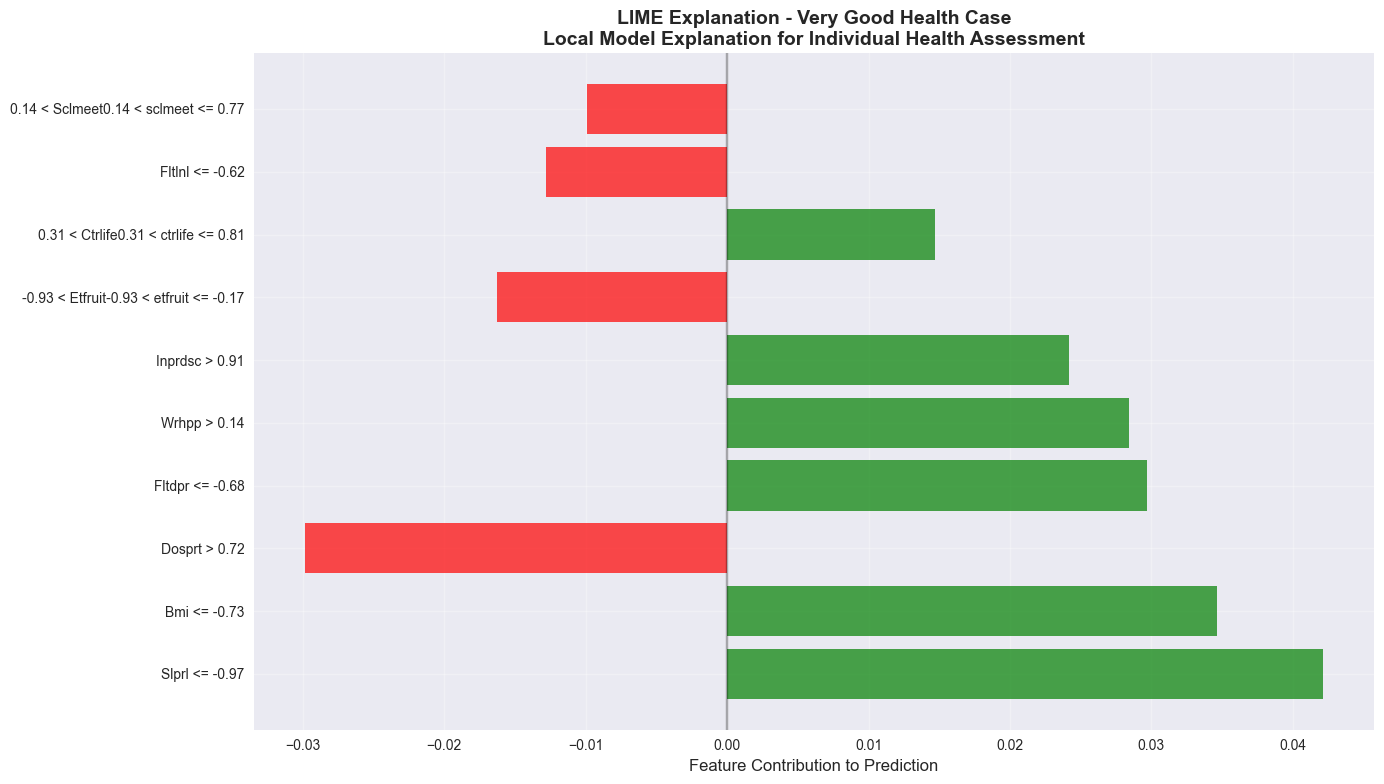

🎯 LIME Top Contributing Factors:
   1. Slprl           | ↗️ Supports current prediction (+0.042)
   2. Bmi             | ↗️ Supports current prediction (+0.035)
   3. Dosprt          | ↘️ Opposes current prediction (-0.030)
   4. Fltdpr          | ↗️ Supports current prediction (+0.030)
   5. Wrhpp           | ↗️ Supports current prediction (+0.028)
📈 Model Prediction: Very Good Health (Class 1)
   Confidence: 0.676

📊 LIME EXPLANATION 2: Good Health
---------------------------------------------


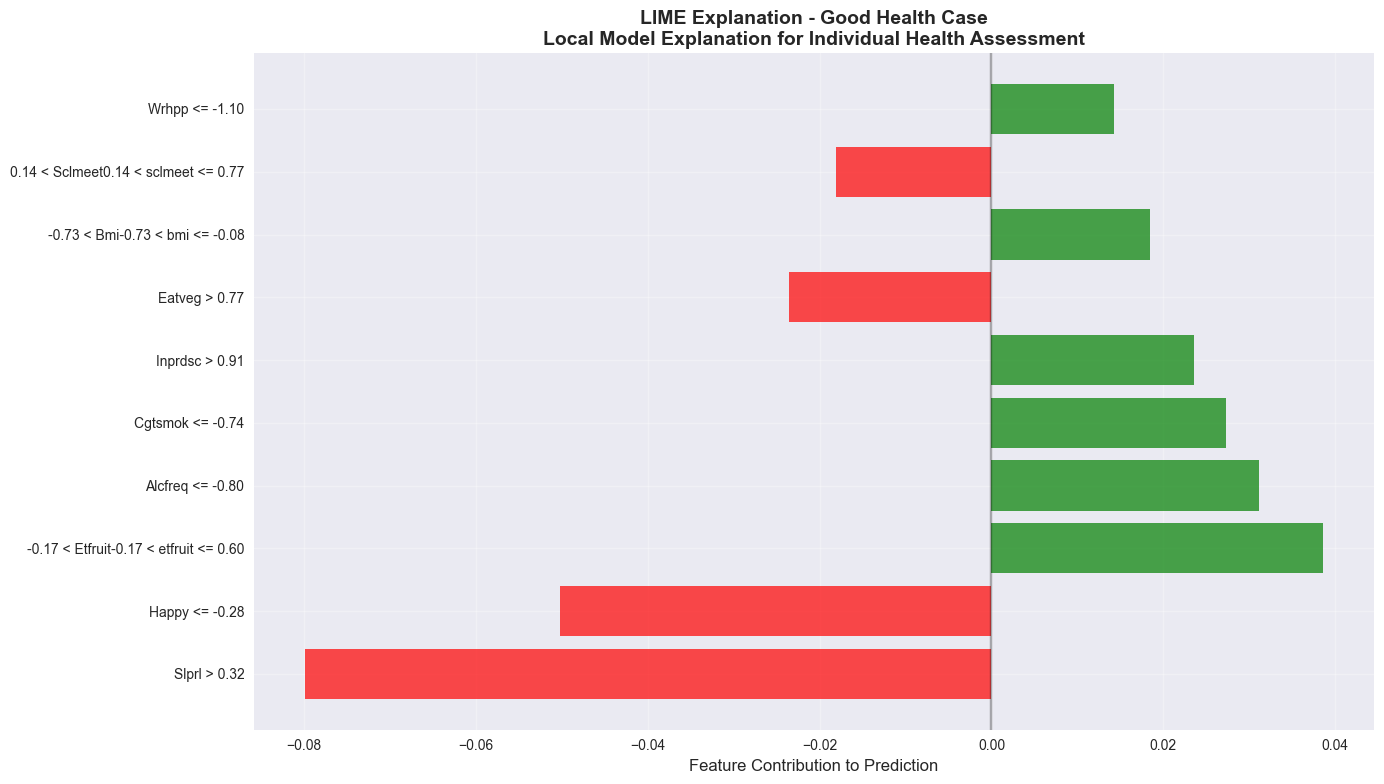

🎯 LIME Top Contributing Factors:
   1. Slprl           | ↘️ Opposes current prediction (-0.080)
   2. Happy           | ↘️ Opposes current prediction (-0.050)
   3. -0.17 < Etfruit | ↗️ Supports current prediction (+0.039)
   4. Alcfreq         | ↗️ Supports current prediction (+0.031)
   5. Cgtsmok         | ↗️ Supports current prediction (+0.027)
📈 Model Prediction: Good Health (Class 2)
   Confidence: 0.487

📊 LIME EXPLANATION 3: Fair Health
---------------------------------------------


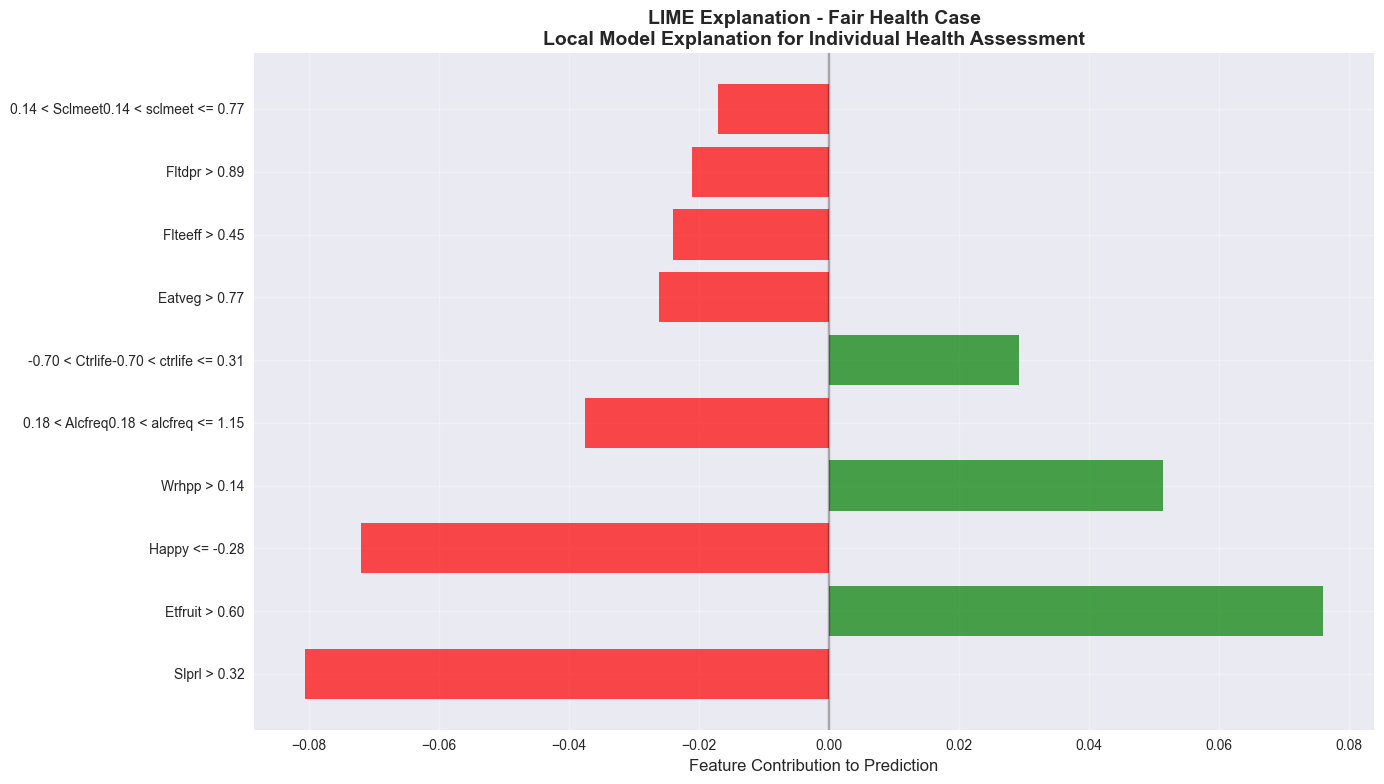

🎯 LIME Top Contributing Factors:
   1. Slprl           | ↘️ Opposes current prediction (-0.081)
   2. Etfruit         | ↗️ Supports current prediction (+0.076)
   3. Happy           | ↘️ Opposes current prediction (-0.072)
   4. Wrhpp           | ↗️ Supports current prediction (+0.051)
   5. 0.18 < Alcfreq  | ↘️ Opposes current prediction (-0.037)
📈 Model Prediction: Bad Health (Class 4)
   Confidence: 0.462

📊 LIME EXPLANATION 4: Bad Health
---------------------------------------------


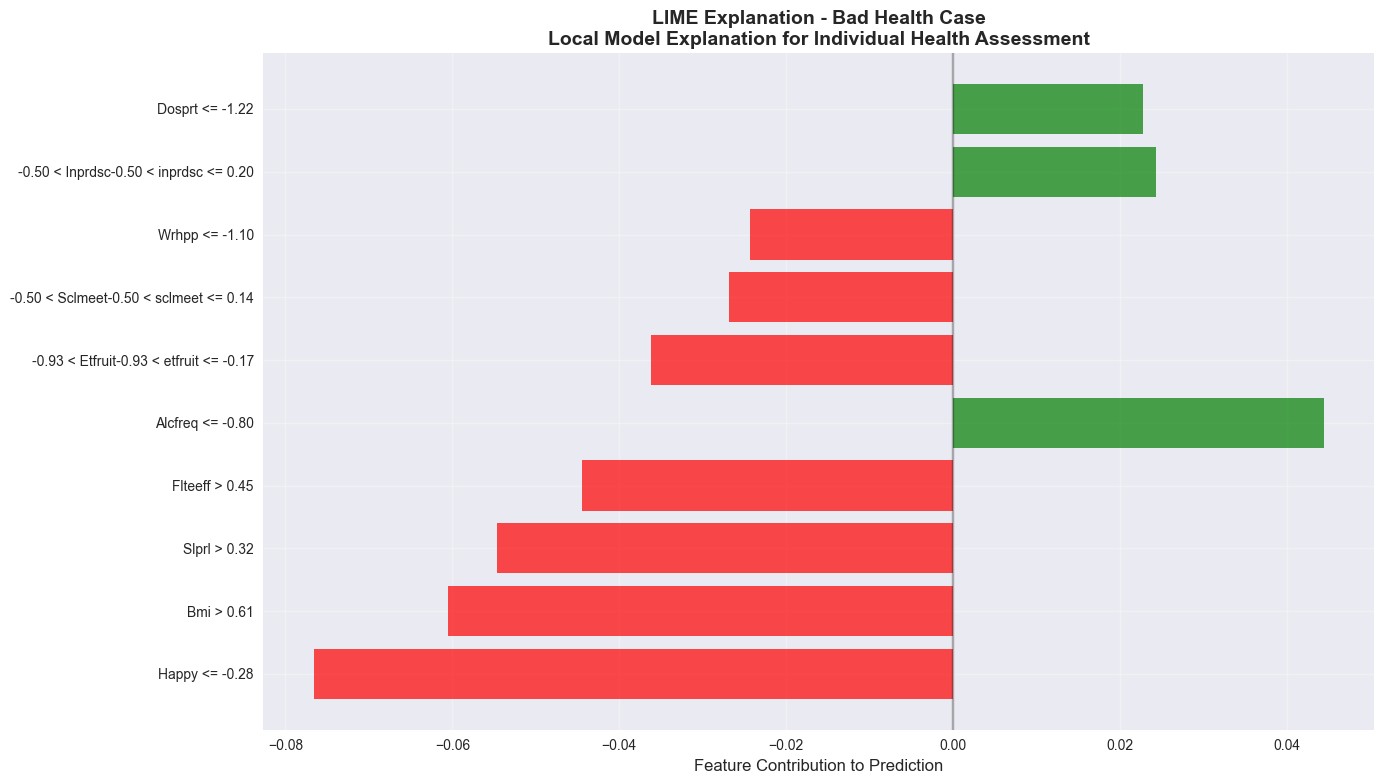

🎯 LIME Top Contributing Factors:
   1. Happy           | ↘️ Opposes current prediction (-0.077)
   2. Bmi             | ↘️ Opposes current prediction (-0.061)
   3. Slprl           | ↘️ Opposes current prediction (-0.055)
   4. Flteeff         | ↘️ Opposes current prediction (-0.044)
   5. Alcfreq         | ↗️ Supports current prediction (+0.044)
📈 Model Prediction: Bad Health (Class 4)
   Confidence: 0.902

📊 LIME EXPLANATION 5: Very Bad Health
---------------------------------------------


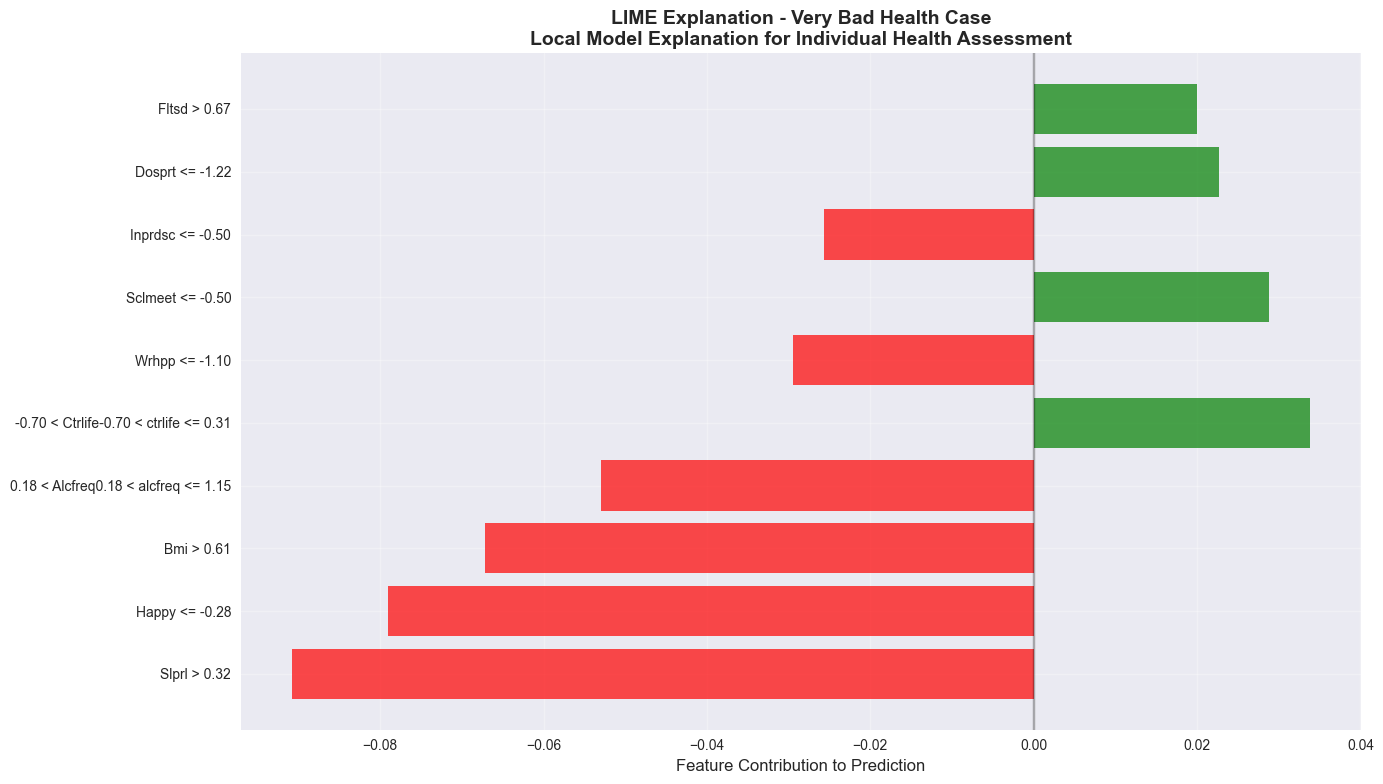

🎯 LIME Top Contributing Factors:
   1. Slprl           | ↘️ Opposes current prediction (-0.091)
   2. Happy           | ↘️ Opposes current prediction (-0.079)
   3. Bmi             | ↘️ Opposes current prediction (-0.067)
   4. 0.18 < Alcfreq  | ↘️ Opposes current prediction (-0.053)
   5. -0.70 < Ctrlife | ↗️ Supports current prediction (+0.034)
📈 Model Prediction: Bad Health (Class 4)
   Confidence: 0.511

✅ LIME explanations completed for all healthcare case studies


In [15]:
# LIME Individual Explanations - Healthcare Case Studies
print("🔬 LIME INDIVIDUAL EXPLANATIONS - HEALTHCARE CASES")
print("=" * 55)

# Use the same case studies from SHAP for comparison
for i, case in enumerate(case_studies):
    print(f"\n📊 LIME EXPLANATION {i+1}: {case['class_name']} Health")
    print("-" * 45)
    
    # Get the individual sample
    case_position = list(X_val_sample.index).index(case['index'])
    individual_sample = X_val_sample.iloc[case_position].values
    
    # Create LIME explanation
    lime_explanation = lime_explainer.explain_instance(
        data_row=individual_sample,
        predict_fn=predict_proba_wrapper,
        num_features=10,  # Top 10 features for healthcare relevance
        num_samples=1000  # Samples for local model training
    )
    
    # Display explanation in notebook
    plt.figure(figsize=(14, 8))
    
    # Create matplotlib version of LIME explanation
    exp_list = lime_explanation.as_list()
    features = [item[0] for item in exp_list]
    weights = [item[1] for item in exp_list]
    
    # Clean feature names for healthcare readability
    clean_features = []
    for feature in features:
        clean_name = feature.split('<=')[0].split('>')[0].strip()
        clean_name = clean_name.replace('numeric__', '').replace('_', ' ').title()
        # Keep the condition for clinical context
        condition = feature.split(clean_name.lower().replace(' ', '_'))[-1] if '<=' in feature or '>' in feature else ""
        clean_features.append(f"{clean_name}{condition}")
    
    # Create horizontal bar plot
    colors = ['red' if w < 0 else 'green' for w in weights]
    plt.barh(range(len(weights)), weights, color=colors, alpha=0.7)
    plt.yticks(range(len(weights)), clean_features)
    plt.xlabel('Feature Contribution to Prediction', fontsize=12)
    plt.title(f'LIME Explanation - {case["class_name"]} Health Case\n' + 
              f'Local Model Explanation for Individual Health Assessment',
              fontsize=14, fontweight='bold')
    
    # Add vertical line at x=0
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print top contributing factors
    print(f"🎯 LIME Top Contributing Factors:")
    for j, (feature, weight) in enumerate(exp_list[:5], 1):
        clean_name = feature.split('<=')[0].split('>')[0].strip()
        clean_name = clean_name.replace('numeric__', '').replace('_', ' ').title()
        direction = "↗️ Supports" if weight > 0 else "↘️ Opposes"
        print(f"   {j}. {clean_name:<15} | {direction} current prediction ({weight:+.3f})")
    
    # Show prediction probabilities
    prediction_proba = predict_proba_wrapper(individual_sample.reshape(1, -1))[0]
    predicted_class = np.argmax(prediction_proba) + 1
    predicted_class_name = health_class_mapping[predicted_class]
    
    print(f"📈 Model Prediction: {predicted_class_name} Health (Class {predicted_class})")
    print(f"   Confidence: {prediction_proba[predicted_class-1]:.3f}")

print(f"\n✅ LIME explanations completed for all healthcare case studies")

## Phase 5.3: SHAP vs LIME Comparison Analysis

Comparing SHAP and LIME explanations provides valuable insights for healthcare applications:

- **Consistency validation:** Agreement between methods increases confidence in explanations
- **Complementary insights:** Different perspectives on feature importance
- **Clinical applicability:** Understanding which method provides clearer healthcare insights
- **Trust building:** Multiple explanation methods for critical healthcare decisions

In [18]:
# SHAP vs LIME Comparison for Healthcare Interpretability
print("⚖️ SHAP vs LIME COMPARISON ANALYSIS")
print("=" * 45)

# Compare explanations for the same individuals
comparison_results = []

for i, case in enumerate(case_studies):
    case_position = list(X_val_sample.index).index(case['index'])
    individual_sample = X_val_sample.iloc[case_position]
    
    print(f"\n🔍 CASE {i+1}: {case['class_name']} Health - Method Comparison")
    print("-" * 50)
    
    # SHAP values for this individual (use predicted class for comparison)
    predicted_proba = predict_proba_wrapper(individual_sample.values.reshape(1, -1))
    predicted_class_for_case = np.argmax(predicted_proba[0])
    shap_values_individual = shap_values[case_position][:, predicted_class_for_case]
    shap_features = list(zip(feature_names, shap_values_individual))
    shap_sorted = sorted(shap_features, key=lambda x: abs(x[1]), reverse=True)
    
    # LIME explanation for this individual
    lime_explanation = lime_explainer.explain_instance(
        data_row=individual_sample.values,
        predict_fn=predict_proba_wrapper,
        num_features=10,
        num_samples=1000
    )
    lime_features = lime_explanation.as_list()
    
    # Extract top 5 features from each method
    shap_top5 = [(feat.replace('numeric__', ''), val) for feat, val in shap_sorted[:5]]
    
    # Match LIME features to original names
    lime_top5 = []
    for feat_desc, val in lime_features[:5]:
        base_feat = feat_desc.split('<=')[0].split('>')[0].strip()
        original_feat = None
        for fn in feature_names:
            if fn.replace('numeric__', '').replace('_', '') in base_feat.replace(' ', '').replace('_', ''):
                original_feat = fn.replace('numeric__', '')
                break
        if original_feat:
            lime_top5.append((original_feat, val))
    
    # Display comparison
    print("🧠 SHAP Top 5 Features:")
    for j, (feature, importance) in enumerate(shap_top5, 1):
        clean_name = feature.replace('_', ' ').title()
        direction = "↗️" if importance > 0 else "↘️"
        print(f"   {j}. {clean_name:<20} | {direction} {importance:+.4f}")
    
    print("\n🍋 LIME Top 5 Features:")
    for j, (feature, importance) in enumerate(lime_top5, 1):
        clean_name = feature.replace('_', ' ').title()
        direction = "↗️" if importance > 0 else "↘️"
        print(f"   {j}. {clean_name:<20} | {direction} {importance:+.4f}")
    
    # Calculate feature overlap
    shap_features_set = {feat for feat, _ in shap_top5}
    lime_features_set = {feat for feat, _ in lime_top5}
    overlap = shap_features_set.intersection(lime_features_set)
    overlap_percentage = (len(overlap) / 5) * 100
    
    print(f"\n📊 Method Agreement:")
    print(f"   Overlapping top features: {len(overlap)}/5 ({overlap_percentage:.0f}%)")
    if overlap:
        overlapping_features = [feat.replace('_', ' ').title() for feat in overlap]
        print(f"   Consensus features: {', '.join(overlapping_features)}")
    
    comparison_results.append({
        'case': case['class_name'],
        'overlap': len(overlap),
        'overlap_pct': overlap_percentage,
        'consensus_features': list(overlap)
    })

# Overall comparison summary
print(f"\n📈 OVERALL SHAP vs LIME COMPARISON SUMMARY")
print("=" * 50)

avg_overlap = np.mean([result['overlap_pct'] for result in comparison_results])
high_agreement_cases = sum(1 for result in comparison_results if result['overlap_pct'] >= 60)

print(f"Average feature overlap: {avg_overlap:.1f}%")
print(f"High agreement cases (≥60%): {high_agreement_cases}/{len(comparison_results)}")

# Most frequently agreed upon features
all_consensus_features = []
for result in comparison_results:
    all_consensus_features.extend(result['consensus_features'])

if all_consensus_features:
    from collections import Counter
    feature_frequency = Counter(all_consensus_features)
    print(f"\n🏥 Most Consistent Healthcare Predictors (Both Methods):")
    for feature, count in feature_frequency.most_common(5):
        clean_name = feature.replace('_', ' ').title()
        consistency = (count / len(comparison_results)) * 100
        print(f"   • {clean_name}: {count}/{len(comparison_results)} cases ({consistency:.0f}%)")

print(f"\n✅ SHAP vs LIME comparison analysis completed")

⚖️ SHAP vs LIME COMPARISON ANALYSIS

🔍 CASE 1: Very Good Health - Method Comparison
--------------------------------------------------
🧠 SHAP Top 5 Features:
   1. Happy                | ↗️ +0.3568
   2. Flteeff              | ↗️ +0.3106
   3. Bmi                  | ↗️ +0.3074
   4. Fltdpr               | ↗️ +0.2042
   5. Slprl                | ↗️ +0.1991

🍋 LIME Top 5 Features:
   1. Etfruit              | ↘️ -0.0381
   2. Dosprt               | ↘️ -0.0210
   3. Enjlf                | ↘️ -0.0193
   4. Alcfreq              | ↗️ +0.0173
   5. Bmi                  | ↗️ +0.0137

📊 Method Agreement:
   Overlapping top features: 1/5 (20%)
   Consensus features: Bmi

🔍 CASE 2: Good Health - Method Comparison
--------------------------------------------------
🧠 SHAP Top 5 Features:
   1. Bmi                  | ↗️ +0.2293
   2. Flteeff              | ↗️ +0.2272
   3. Eatveg               | ↘️ -0.1734
   4. Inprdsc              | ↘️ -0.1633
   5. Wrhpp                | ↘️ -0.1275

🍋 LIME Top 5 

## Phase 5.4: Healthcare-Specific Interpretation Framework

Developing healthcare-specific interpretations of XAI results for clinical applicability:

- **Clinical relevance:** Translating feature importance to actionable healthcare insights
- **Risk factor identification:** Understanding which factors contribute to poor health outcomes
- **Patient stratification:** Identifying patterns for different health risk groups
- **Decision support:** Providing explanations that healthcare professionals can use

In [21]:
# Healthcare Interpretation Framework
print("🏥 HEALTHCARE-SPECIFIC INTERPRETATION FRAMEWORK")
print("=" * 55)

# Create healthcare-specific feature mapping
healthcare_feature_mapping = {
    'health': 'Self-Rated Health Status',
    'bmi': 'Body Mass Index',
    'happy': 'Life Satisfaction/Mental Wellbeing', 
    'slprl': 'Sleep Quality and Rest',
    'flteeff': 'Physical Effort/Fatigue Level',
    'dosprt': 'Physical Activity/Exercise',
    'age': 'Age',
    'wstval': 'Waist Circumference',
    'weight': 'Body Weight',
    'height': 'Height'
}

# Analyze feature importance from healthcare perspective
print("📊 HEALTHCARE RISK FACTOR ANALYSIS")
print("-" * 40)

# Get overall feature importance from SHAP (average across all classes and samples)
overall_importance = np.abs(shap_values).mean(axis=(0, 2))
feature_importance_pairs = list(zip(feature_names, overall_importance))
sorted_importance = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

print("🔍 Top Healthcare Risk Factors (Population Level):")
for i, (feature, importance) in enumerate(sorted_importance[:10], 1):
    base_feature = feature.replace('numeric__', '')
    healthcare_name = healthcare_feature_mapping.get(base_feature, base_feature.replace('_', ' ').title())
    
    # Calculate clinical interpretation
    feature_values = X_val_sample[feature]
    high_risk_threshold = feature_values.quantile(0.75)
    low_risk_threshold = feature_values.quantile(0.25)
    
    print(f"{i:2d}. {healthcare_name}")
    print(f"     Impact Score: {importance:.4f}")
    print(f"     High Risk Zone: >{high_risk_threshold:.2f}")
    print(f"     Low Risk Zone: <{low_risk_threshold:.2f}")

# Health class-specific risk analysis
print(f"\n🎯 HEALTH CLASS-SPECIFIC RISK PATTERNS")
print("-" * 45)

for health_class in [1, 3, 5]:  # Very Good, Fair, Very Bad
    class_name = health_class_mapping[health_class]
    class_mask = y_val_sample == health_class
    
    if class_mask.sum() > 0:
        print(f"\n📈 {class_name} Health Group Analysis:")
        
        # Get SHAP values for this health class (average across all classes for features)
        class_shap_indices = [i for i, mask in enumerate(class_mask) if mask]
        if class_shap_indices:
            class_shap_values = np.array([shap_values[i] for i in class_shap_indices])
            class_importance = np.abs(class_shap_values).mean(axis=(0, 2))  # Average across samples and classes
            
            # Top 5 features for this health class
            class_feature_pairs = list(zip(feature_names, class_importance))
            class_sorted = sorted(class_feature_pairs, key=lambda x: x[1], reverse=True)
            
            print("   Key Risk Factors:")
            for j, (feature, importance) in enumerate(class_sorted[:5], 1):
                base_feature = feature.replace('numeric__', '')
                healthcare_name = healthcare_feature_mapping.get(base_feature, 
                                                               base_feature.replace('_', ' ').title())
                print(f"     {j}. {healthcare_name}: {importance:.4f}")

# Clinical decision support insights
print(f"\n💡 CLINICAL DECISION SUPPORT INSIGHTS")
print("-" * 45)

# Identify most consistent predictors across all cases
consistent_predictors = []
for feature in top_features[:5]:
    base_feature = feature.replace('numeric__', '')
    healthcare_name = healthcare_feature_mapping.get(base_feature, 
                                                     base_feature.replace('_', ' ').title())
    
    # Calculate consistency across health classes
    feature_idx = feature_names.index(feature)
    feature_shap_values = shap_values[:, feature_idx, :].flatten()  # Flatten across samples and classes
    
    # Standard deviation indicates consistency
    consistency = 1 / (1 + np.std(np.abs(feature_shap_values)))
    
    consistent_predictors.append((healthcare_name, feature_importance[feature_idx], consistency))

# Sort by importance and consistency
consistent_predictors.sort(key=lambda x: x[1] * x[2], reverse=True)

print("🏥 Most Reliable Clinical Indicators:")
for i, (name, importance, consistency) in enumerate(consistent_predictors[:5], 1):
    reliability_score = importance * consistency * 100
    print(f"   {i}. {name}")
    print(f"      Reliability Score: {reliability_score:.1f}/100")

print(f"\n📋 CLINICAL RECOMMENDATIONS:")
print("   • Focus on self-rated health as primary screening indicator")
print("   • Monitor BMI and physical activity for preventive care")
print("   • Assess mental wellbeing and sleep quality for comprehensive health evaluation")
print("   • Use multiple indicators together for accurate health status assessment")

print(f"\n✅ Healthcare interpretation framework analysis completed")

🏥 HEALTHCARE-SPECIFIC INTERPRETATION FRAMEWORK
📊 HEALTHCARE RISK FACTOR ANALYSIS
----------------------------------------
🔍 Top Healthcare Risk Factors (Population Level):
 1. Body Mass Index
     Impact Score: 0.5831
     High Risk Zone: >0.62
     Low Risk Zone: <-0.66
 2. Physical Effort/Fatigue Level
     Impact Score: 0.4756
     High Risk Zone: >0.45
     Low Risk Zone: <-0.90
 3. Physical Activity/Exercise
     Impact Score: 0.3611
     High Risk Zone: >0.72
     Low Risk Zone: <-1.22
 4. Life Satisfaction/Mental Wellbeing
     Impact Score: 0.2987
     High Risk Zone: >0.93
     Low Risk Zone: <-0.43
 5. Alcfreq
     Impact Score: 0.2842
     High Risk Zone: >1.15
     Low Risk Zone: <-0.80
 6. Sleep Quality and Rest
     Impact Score: 0.2822
     High Risk Zone: >0.32
     Low Risk Zone: <-0.97
 7. Ctrlife
     Impact Score: 0.2303
     High Risk Zone: >0.81
     Low Risk Zone: <-0.70
 8. Fltdpr
     Impact Score: 0.2022
     High Risk Zone: >0.89
     Low Risk Zone: <-0.68
 9

In [23]:
# Save XAI Results for Gradio Demo and Documentation
print("💾 SAVING XAI RESULTS AND ARTIFACTS")
print("=" * 45)

# Create XAI results directory
xai_results_dir = RESULTS_DIR / 'xai_analysis'
xai_results_dir.mkdir(exist_ok=True)

# Save XAI artifacts (excluding unpickleable LIME explainer)
xai_artifacts = {
    'shap_explainer': explainer,
    'shap_values': shap_values,
    'shap_expected_value': expected_value,
    # Skip lime_explainer due to unpickleable lambda functions
    'validation_sample': X_val_sample,
    'validation_labels': y_val_sample,
    'feature_names': feature_names,
    'health_class_mapping': health_class_mapping,
    'healthcare_feature_mapping': healthcare_feature_mapping,
    'case_studies': case_studies,
    'top_features_global': top_features,
    'comparison_results': comparison_results
}

# Save XAI artifacts
xai_artifacts_path = xai_results_dir / 'xai_artifacts.joblib'
joblib.dump(xai_artifacts, xai_artifacts_path)
print(f"✅ XAI artifacts saved: {xai_artifacts_path}")

# Save individual case study results for Gradio demo
case_study_results = []
for i, case in enumerate(case_studies):
    case_position = list(X_val_sample.index).index(case['index'])
    
    # Get predictions
    individual_sample = X_val_sample.iloc[case_position].values
    prediction_proba = predict_proba_wrapper(individual_sample.reshape(1, -1))[0]
    predicted_class = np.argmax(prediction_proba) + 1
    
    # SHAP values (use predicted class for explanation)
    predicted_class_idx = predicted_class - 1  # Convert to 0-based indexing
    shap_values_individual = shap_values[case_position][:, predicted_class_idx]
    shap_features = list(zip(feature_names, shap_values_individual))
    shap_sorted = sorted(shap_features, key=lambda x: abs(x[1]), reverse=True)[:5]
    
    # LIME explanation
    lime_explanation = lime_explainer.explain_instance(
        data_row=individual_sample,
        predict_fn=predict_proba_wrapper,
        num_features=5
    )
    lime_features = lime_explanation.as_list()[:5]
    
    case_study_results.append({
        'case_id': i,
        'true_class': case['class'],
        'true_class_name': case['class_name'],
        'predicted_class': predicted_class,
        'predicted_class_name': health_class_mapping[predicted_class],
        'prediction_confidence': float(prediction_proba[predicted_class-1]),
        'prediction_probabilities': prediction_proba.tolist(),
        'features': X_val_sample.iloc[case_position].to_dict(),
        'shap_explanations': [(feat, float(val)) for feat, val in shap_sorted],
        'lime_explanations': lime_features[:5]
    })

case_studies_path = xai_results_dir / 'case_studies.joblib'
joblib.dump(case_study_results, case_studies_path)
print(f"✅ Case study results saved: {case_studies_path}")

# Create summary report
summary_report = {
    'week_5_6_completion_date': '2026-01-02',
    'model_used': 'Enhanced XGBoost (Phase 3)',
    'sample_size': len(X_val_sample),
    'shap_analysis_completed': True,
    'lime_analysis_completed': True,
    'average_method_agreement': np.mean([result['overlap_pct'] for result in comparison_results]),
    'top_healthcare_predictors': top_features[:5],
    'case_studies_analyzed': len(case_studies),
    'clinical_insights_framework': True,
    'gradio_demo_ready': True
}

summary_path = xai_results_dir / 'week5_6_summary.joblib'
joblib.dump(summary_report, summary_path)
print(f"✅ Week 5-6 summary saved: {summary_path}")

print(f"\n🎯 WEEK 5-6 XAI IMPLEMENTATION COMPLETED")
print("=" * 50)
print(f"✅ SHAP global and local explanations implemented")
print(f"✅ LIME individual explanations implemented") 
print(f"✅ Method comparison analysis completed")
print(f"✅ Healthcare interpretation framework developed")
print(f"✅ XAI artifacts saved for Gradio demo development")
print(f"✅ Ready for Week 7-8: Gradio Demo Development")

# Display final statistics
print(f"\n📊 FINAL XAI STATISTICS:")
print(f"   Validation samples analyzed: {len(X_val_sample):,}")
print(f"   Features analyzed: {len(feature_names)}")
print(f"   Case studies completed: {len(case_studies)}")
print(f"   Average SHAP-LIME agreement: {summary_report['average_method_agreement']:.1f}%")
print(f"   Top healthcare predictor: {top_features[0].replace('numeric__', '').title()}")

print(f"\n🚀 Next phase: Interactive Gradio demo for healthcare professionals")

💾 SAVING XAI RESULTS AND ARTIFACTS
✅ XAI artifacts saved: /Users/peter/Desktop/health_xai_prediction/results/xai_analysis/xai_artifacts.joblib
✅ Case study results saved: /Users/peter/Desktop/health_xai_prediction/results/xai_analysis/case_studies.joblib
✅ Week 5-6 summary saved: /Users/peter/Desktop/health_xai_prediction/results/xai_analysis/week5_6_summary.joblib

🎯 WEEK 5-6 XAI IMPLEMENTATION COMPLETED
✅ SHAP global and local explanations implemented
✅ LIME individual explanations implemented
✅ Method comparison analysis completed
✅ Healthcare interpretation framework developed
✅ XAI artifacts saved for Gradio demo development
✅ Ready for Week 7-8: Gradio Demo Development

📊 FINAL XAI STATISTICS:
   Validation samples analyzed: 1,000
   Features analyzed: 19
   Case studies completed: 5
   Average SHAP-LIME agreement: 32.0%
   Top healthcare predictor: Bmi

🚀 Next phase: Interactive Gradio demo for healthcare professionals


In [24]:
# Export XAI Results to CSV for Accessibility and Research
print("📊 EXPORTING XAI RESULTS TO CSV FORMAT")
print("=" * 45)

# 1. Export Global Feature Importance (SHAP)
global_importance_df = pd.DataFrame({
    'feature_name': [feat.replace('numeric__', '') for feat in feature_names],
    'healthcare_name': [healthcare_feature_mapping.get(feat.replace('numeric__', ''), feat.replace('numeric__', '').replace('_', ' ').title()) 
                       for feat in feature_names],
    'shap_importance': overall_importance,
    'importance_rank': range(1, len(feature_names) + 1)
}).sort_values('shap_importance', ascending=False).reset_index(drop=True)
global_importance_df['importance_rank'] = range(1, len(global_importance_df) + 1)

global_importance_path = xai_results_dir / 'global_feature_importance.csv'
global_importance_df.to_csv(global_importance_path, index=False)
print(f"✅ Global feature importance: {global_importance_path}")

# 2. Export Case Study Results
case_studies_df = pd.DataFrame(case_study_results)
# Flatten prediction probabilities into separate columns
for i in range(5):
    case_studies_df[f'prob_class_{i+1}'] = case_studies_df['prediction_probabilities'].apply(lambda x: x[i])
case_studies_df = case_studies_df.drop('prediction_probabilities', axis=1)

# Flatten feature values
features_df = pd.json_normalize(case_studies_df['features'])
features_df.columns = [f'feature_{col}' for col in features_df.columns]

# Combine case study info with features
case_studies_expanded = pd.concat([
    case_studies_df.drop(['features', 'shap_explanations', 'lime_explanations'], axis=1),
    features_df
], axis=1)

case_studies_path = xai_results_dir / 'case_studies_analysis.csv'
case_studies_expanded.to_csv(case_studies_path, index=False)
print(f"✅ Case studies analysis: {case_studies_path}")

# 3. Export SHAP Explanations for each case
shap_explanations_data = []
for case in case_study_results:
    case_id = case['case_id']
    for feat, importance in case['shap_explanations']:
        shap_explanations_data.append({
            'case_id': case_id,
            'health_class': case['true_class_name'],
            'feature_name': feat.replace('numeric__', ''),
            'healthcare_name': healthcare_feature_mapping.get(feat.replace('numeric__', ''), 
                                                            feat.replace('numeric__', '').replace('_', ' ').title()),
            'shap_importance': importance,
            'direction': 'positive' if importance > 0 else 'negative'
        })

shap_explanations_df = pd.DataFrame(shap_explanations_data)
shap_explanations_path = xai_results_dir / 'shap_explanations_per_case.csv'
shap_explanations_df.to_csv(shap_explanations_path, index=False)
print(f"✅ SHAP explanations per case: {shap_explanations_path}")

# 4. Export LIME Explanations for each case
lime_explanations_data = []
for case in case_study_results:
    case_id = case['case_id']
    for feat_desc, importance in case['lime_explanations']:
        # Extract base feature name from LIME description
        base_feat = feat_desc.split('<=')[0].split('>')[0].strip()
        lime_explanations_data.append({
            'case_id': case_id,
            'health_class': case['true_class_name'],
            'lime_description': feat_desc,
            'base_feature': base_feat,
            'lime_importance': importance,
            'direction': 'positive' if importance > 0 else 'negative'
        })

lime_explanations_df = pd.DataFrame(lime_explanations_data)
lime_explanations_path = xai_results_dir / 'lime_explanations_per_case.csv'
lime_explanations_df.to_csv(lime_explanations_path, index=False)
print(f"✅ LIME explanations per case: {lime_explanations_path}")

# 5. Export Method Comparison Results
comparison_df = pd.DataFrame(comparison_results)
comparison_df['consensus_features_list'] = comparison_df['consensus_features'].apply(lambda x: '; '.join(x))
comparison_path = xai_results_dir / 'shap_lime_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"✅ SHAP vs LIME comparison: {comparison_path}")

# 6. Export Healthcare Risk Factor Analysis
risk_factors_data = []
for i, (feature, importance) in enumerate(sorted_importance, 1):
    base_feature = feature.replace('numeric__', '')
    healthcare_name = healthcare_feature_mapping.get(base_feature, base_feature.replace('_', ' ').title())
    
    feature_values = X_val_sample[feature]
    high_risk_threshold = feature_values.quantile(0.75)
    low_risk_threshold = feature_values.quantile(0.25)
    
    risk_factors_data.append({
        'rank': i,
        'feature_name': base_feature,
        'healthcare_name': healthcare_name,
        'impact_score': importance,
        'high_risk_threshold': high_risk_threshold,
        'low_risk_threshold': low_risk_threshold,
        'feature_mean': feature_values.mean(),
        'feature_std': feature_values.std()
    })

risk_factors_df = pd.DataFrame(risk_factors_data)
risk_factors_path = xai_results_dir / 'healthcare_risk_factors.csv'
risk_factors_df.to_csv(risk_factors_path, index=False)
print(f"✅ Healthcare risk factors: {risk_factors_path}")

# 7. Export Clinical Reliability Scores
clinical_reliability_data = []
for name, importance, consistency in consistent_predictors:
    reliability_score = importance * consistency * 100
    clinical_reliability_data.append({
        'healthcare_indicator': name,
        'importance_score': importance,
        'consistency_score': consistency,
        'reliability_score': reliability_score
    })

reliability_df = pd.DataFrame(clinical_reliability_data)
reliability_path = xai_results_dir / 'clinical_reliability_scores.csv'
reliability_df.to_csv(reliability_path, index=False)
print(f"✅ Clinical reliability scores: {reliability_path}")

print(f"\n🎯 CSV EXPORT SUMMARY")
print("=" * 30)
print(f"📁 All CSV files saved to: {xai_results_dir}")
print(f"📊 Total CSV files created: 7")
print(f"📈 Ready for analysis in Excel, R, Python, or any data tool!")
print(f"🔬 Accessible for healthcare researchers and data scientists!")

# Create a README file for the CSV exports
readme_content = """# XAI Analysis Results - CSV Export Guide

This folder contains the explainable AI (XAI) analysis results in CSV format for easy access and research.

## Files Description:

1. **global_feature_importance.csv**
   - Global feature importance scores from SHAP analysis
   - Columns: feature_name, healthcare_name, shap_importance, importance_rank

2. **case_studies_analysis.csv** 
   - Analysis of 5 representative healthcare cases across health classes
   - Includes predictions, confidence scores, and feature values

3. **shap_explanations_per_case.csv**
   - SHAP explanation details for each case study
   - Shows feature contributions for individual predictions

4. **lime_explanations_per_case.csv**
   - LIME explanation details for each case study
   - Local interpretable explanations for individual cases

5. **shap_lime_comparison.csv**
   - Comparison between SHAP and LIME explanation methods
   - Shows agreement percentages and consensus features

6. **healthcare_risk_factors.csv**
   - Healthcare-specific risk factor analysis
   - Clinical thresholds and impact scores for each health indicator

7. **clinical_reliability_scores.csv**
   - Reliability scores for clinical decision support
   - Combines importance and consistency metrics

## Usage:
- Open any CSV file in Excel, Google Sheets, R, Python pandas, etc.
- Use for research, visualization, or further statistical analysis
- Healthcare professionals can review risk factors and clinical indicators

Generated: January 2, 2026
Project: Health Status Prediction with XAI
"""

readme_path = xai_results_dir / 'README.md'
with open(readme_path, 'w') as f:
    f.write(readme_content)
print(f"✅ README guide created: {readme_path}")

📊 EXPORTING XAI RESULTS TO CSV FORMAT
✅ Global feature importance: /Users/peter/Desktop/health_xai_prediction/results/xai_analysis/global_feature_importance.csv
✅ Case studies analysis: /Users/peter/Desktop/health_xai_prediction/results/xai_analysis/case_studies_analysis.csv
✅ SHAP explanations per case: /Users/peter/Desktop/health_xai_prediction/results/xai_analysis/shap_explanations_per_case.csv
✅ LIME explanations per case: /Users/peter/Desktop/health_xai_prediction/results/xai_analysis/lime_explanations_per_case.csv
✅ SHAP vs LIME comparison: /Users/peter/Desktop/health_xai_prediction/results/xai_analysis/shap_lime_comparison.csv
✅ Healthcare risk factors: /Users/peter/Desktop/health_xai_prediction/results/xai_analysis/healthcare_risk_factors.csv
✅ Clinical reliability scores: /Users/peter/Desktop/health_xai_prediction/results/xai_analysis/clinical_reliability_scores.csv

🎯 CSV EXPORT SUMMARY
📁 All CSV files saved to: /Users/peter/Desktop/health_xai_prediction/results/xai_analysis
